# Task 1 (MNIST + OOP) and Task 2 (Animal Classification + Pretrained NER)

This single notebook demonstrates:
1. **Task 1**: Implement MNIST classification using an OOP approach:
   - An interface (`MnistClassifierInterface`) with 2 methods: `train` and `predict`
   - Three classes implementing this interface: Random Forest, Feed-Forward NN, CNN
   - A wrapper class `MnistClassifier` that takes `algorithm='rf'|'nn'|'cnn'`
2. **Task 2**:
   - A CNN trained on 10 animal classes from CIFAR-100.
   - A **pretrained** NER model from Hugging Face (`dslim/bert-base-NER`) to detect any of those animals in text.
   - An end-to-end pipeline that returns a boolean `True` or `False` indicating whether the text's mentioned animal matches the image's predicted class.


I'm choosing to use a Jupyter notebook because Docker and VS Code environments have caused persistent dependency and configuration issues, leading to long build times and debugging headaches. Given the one-week deadline, Jupyter offers a ready-to-use, minimal-overhead environment that lets me focus on coding and quickly iterate without the extra complexity.

## 1. Task 1: MNIST + OOP

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from abc import ABC, abstractmethod
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pytorch_lightning as pl

pl.seed_everything(42)  # For reproducibility

c:\Users\maksy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

### 1.1. Define the Interface

In [2]:
class MnistClassifierInterface(ABC):
    """
    Interface requiring two abstract methods:
     - train(train_data, train_targets)
     - predict(test_data)
    """
    @abstractmethod
    def train(self, train_data, train_targets):
        pass

    @abstractmethod
    def predict(self, test_data):
        pass

### 1.2. Random Forest Classifier

In [3]:
class RfMnistClassifier(MnistClassifierInterface):
    def __init__(self, n_estimators=100):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    def train(self, train_data, train_targets):
        self.model.fit(train_data, train_targets)

    def predict(self, test_data):
        return self.model.predict(test_data)

### 1.3. Feed-Forward NN

In [4]:
class FeedForwardMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.layers(x)

class NnMnistClassifier(MnistClassifierInterface):
    def __init__(self, epochs=5, lr=1e-3, batch_size=64):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.model = FeedForwardMnist()

    def train(self, train_data, train_targets):
        X = torch.from_numpy(train_data).float()
        y = torch.from_numpy(train_targets).long()
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for batch_x, batch_y in loader:
                optimizer.zero_grad()
                out = self.model(batch_x)
                loss = criterion(out, batch_y)
                loss.backward()
                optimizer.step()

    def predict(self, test_data):
        X = torch.from_numpy(test_data).float()
        self.model.eval()
        with torch.no_grad():
            out = self.model(X)
            preds = torch.argmax(out, dim=1)
        return preds.numpy()

### 1.4. CNN Classifier

In [5]:
class ConvMnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

class CnnMnistClassifier(MnistClassifierInterface):
    def __init__(self, epochs=5, lr=1e-3, batch_size=64):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.model = ConvMnistNet()

    def train(self, train_data, train_targets):
        X = torch.from_numpy(train_data).float().view(-1,1,28,28)
        y = torch.from_numpy(train_targets).long()
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for batch_x, batch_y in loader:
                optimizer.zero_grad()
                out = self.model(batch_x)
                loss = criterion(out, batch_y)
                loss.backward()
                optimizer.step()

    def predict(self, test_data):
        X = torch.from_numpy(test_data).float().view(-1,1,28,28)
        self.model.eval()
        with torch.no_grad():
            out = self.model(X)
            preds = torch.argmax(out, dim=1)
        return preds.numpy()

### 1.5. Wrapper Class

In [6]:
class MnistClassifier:
    def __init__(self, algorithm='rf'):
        if algorithm == 'rf':
            self.impl = RfMnistClassifier()
        elif algorithm == 'nn':
            self.impl = NnMnistClassifier()
        elif algorithm == 'cnn':
            self.impl = CnnMnistClassifier()
        else:
            raise ValueError(f"Unsupported algorithm: {algorithm}")

    def train(self, train_data, train_targets):
        self.impl.train(train_data, train_targets)

    def predict(self, test_data):
        return self.impl.predict(test_data)

### 1.6. Demo on MNIST

In [7]:
# Load MNIST and do a small training demo
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

train_mnist = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=mnist_transform)
test_mnist = torchvision.datasets.MNIST(root='./mnist_data', train=False, download=True, transform=mnist_transform)

# We'll just take 5k from the training set to keep it quick
train_small, _ = random_split(train_mnist, [5000, len(train_mnist)-5000])

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, label in dataset:
        # img is a PIL Image or Tensor of shape (1,28,28)
        # We'll convert to numpy shape (28,28)
        np_img = np.array(img).astype(np.float32)
        images.append(np_img)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Convert
X_train_mnist, y_train_mnist = dataset_to_numpy(train_small)
X_test_mnist, y_test_mnist = dataset_to_numpy(test_mnist)

# Flatten for rf/nn
X_train_flat = X_train_mnist.reshape(-1, 28*28)
X_test_flat = X_test_mnist.reshape(-1, 28*28)

# 1) Random Forest
rf_model = MnistClassifier(algorithm='rf')
rf_model.train(X_train_flat, y_train_mnist)
rf_preds = rf_model.predict(X_test_flat)
rf_acc = accuracy_score(y_test_mnist, rf_preds)
print("Random Forest Accuracy:", rf_acc)

# 2) Feed-forward NN
nn_model = MnistClassifier(algorithm='nn')
nn_model.train(X_train_flat, y_train_mnist)
nn_preds = nn_model.predict(X_test_flat)
nn_acc = accuracy_score(y_test_mnist, nn_preds)
print("Feed-Forward NN Accuracy:", nn_acc)

# 3) CNN
cnn_model = MnistClassifier(algorithm='cnn')
cnn_model.train(X_train_flat, y_train_mnist)
cnn_preds = cnn_model.predict(X_test_flat)
cnn_acc = accuracy_score(y_test_mnist, cnn_preds)
print("CNN Accuracy:", cnn_acc)

Random Forest Accuracy: 0.9443
Feed-Forward NN Accuracy: 0.9261
CNN Accuracy: 0.9628


# 2. Task 2: Animal Classification + Pretrained NER

We will:
1. Train a CNN on **10 animal classes** from CIFAR-100.
2. Use a **pretrained** Hugging Face NER model to detect known animals in text.
3. Build a pipeline that checks if the recognized animals in text match the CNN’s predicted animal on the image.


### 2.1. Filter CIFAR-100 to 10 Animal Classes

In [8]:
import torchvision.transforms as T
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset

transform_train = T.Compose([
    T.ToTensor()
])
transform_val = T.Compose([
    T.ToTensor()
])

train_full = CIFAR100(root='data', train=True, download=True, transform=transform_train)
test_full = CIFAR100(root='data', train=False, download=True, transform=transform_val)

selected_classes = [
    'aquarium_fish', 'bear', 'beaver', 'camel', 'dolphin',
    'otter', 'seal', 'tiger', 'whale', 'leopard'
]

sel_idx_train = [i for i, (_, lab) in enumerate(train_full)
                 if train_full.classes[lab] in selected_classes]
sel_idx_test  = [i for i, (_, lab) in enumerate(test_full)
                 if test_full.classes[lab] in selected_classes]

train_subset = Subset(train_full, sel_idx_train)
test_subset  = Subset(test_full, sel_idx_test)

def subset_to_tensors(subset):
    data_list, targ_list = [], []
    for img, lab in subset:
        data_list.append(img)
        targ_list.append(lab)
    data_tensor = torch.stack(data_list)
    target_tensor = torch.tensor(targ_list)
    return data_tensor, target_tensor

data_train_anim, targets_train_anim = subset_to_tensors(train_subset)
data_test_anim, targets_test_anim   = subset_to_tensors(test_subset)

print("Train data shape:", data_train_anim.shape)
print("Train targets shape:", targets_train_anim.shape)
print("Test data shape: ", data_test_anim.shape)
print("Test targets shape:", targets_test_anim.shape)

Train data shape: torch.Size([5000, 3, 32, 32])
Train targets shape: torch.Size([5000])
Test data shape:  torch.Size([1000, 3, 32, 32])
Test targets shape: torch.Size([1000])


### 2.2. Train the Animal CNN

In [9]:
import pytorch_lightning as pl
import torch.nn.functional as F

class AnimalCNN(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (torch.argmax(logits, dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (torch.argmax(logits, dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
selected_classes = [
    'aquarium_fish', 'bear', 'beaver', 'camel', 'dolphin',
    'otter', 'seal', 'tiger', 'whale', 'leopard'
]

# Map each of those 10 animal class names to an index in [0..9]
class_to_idx = {cls_name: i for i, cls_name in enumerate(selected_classes)}

def subset_to_tensors_with_remap(subset):
    """
    Returns (data_tensor, target_tensor)
    Remaps original CIFAR-100 label to [0..9].
    """
    data_list, targ_list = [], []
    for img, orig_label in subset:
        # Get the class name from CIFAR-100
        cls_name = subset.dataset.classes[orig_label]
        # Convert that name to a 0..9 index
        remapped_label = class_to_idx[cls_name]
        data_list.append(img)
        targ_list.append(remapped_label)

    data_tensor = torch.stack(data_list)
    target_tensor = torch.tensor(targ_list)
    return data_tensor, target_tensor

data_train_anim, targets_train_anim = subset_to_tensors_with_remap(train_subset)
data_test_anim,  targets_test_anim  = subset_to_tensors_with_remap(test_subset)

from torch.utils.data import TensorDataset, DataLoader

train_dataset_anim = TensorDataset(data_train_anim, targets_train_anim)
test_dataset_anim  = TensorDataset(data_test_anim,  targets_test_anim)

train_loader_anim = DataLoader(train_dataset_anim, batch_size=32, shuffle=True, num_workers=0)
val_loader_anim   = DataLoader(test_dataset_anim,  batch_size=32, shuffle=False, num_workers=0)

animal_model = AnimalCNN(num_classes=10, lr=0.0001)
trainer = pl.Trainer(max_epochs=30)

if __name__ == '__main__':
    trainer.fit(animal_model, train_loader_anim, val_loader_anim)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 93.7 K | train
1 | fc_layers   | Sequential       | 263 K  | train
2 | loss_fn     | CrossEntropyLoss | 0      | train
---------------------------------------------------------
357 K     Trainable params
0         Non-trainable params
357 K     Total params
1.429     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 157/157 [00:04<00:00, 36.43it/s, v_num=26, val_loss=1.130, val_acc=0.595]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 157/157 [00:04<00:00, 36.29it/s, v_num=26, val_loss=1.130, val_acc=0.595]


### 2.3. Pretrained NER Model 
We’ll use a Hugging Face pipeline (e.g. `dslim/bert-base-NER`). We'll then do a simple check:
- The pipeline returns a list of entities with their predicted labels (`PER`, `LOC`, `ORG`, `MISC`, etc.).
- We only care about text that matches one of our `animals_of_interest`.


In [20]:
!pip install transformers --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from transformers import pipeline

# We'll pick 'dslim/bert-base-NER' as an example.
ner_pipeline = pipeline(
    task="ner",
    model="dslim/bert-base-NER",
    tokenizer="dslim/bert-base-NER",
    aggregation_strategy="simple"  # merges subwords
)

animals_of_interest = {
    "aquarium_fish", "bear", "beaver", "camel", "dolphin",
    "otter", "seal", "tiger", "whale", "leopard"
}

def recognize_animals_in_text(text):
    """
    Runs the HF NER pipeline on the given text.
    Returns a list of recognized animals found in `animals_of_interest`.
    """
    entities = ner_pipeline(text)
    recognized = set()

    for ent in entities:
        entity_str = ent['word'].lower().strip(",.!?")
        if entity_str in animals_of_interest:
            recognized.add(entity_str)
    return list(recognized)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


### 2.4. Inference Pipeline: text + image => boolean

In [143]:
from PIL import Image
import numpy as np

def pipeline_inference(text, pil_image, ner_pipe, animals_of_interest, animal_model, class_names):
    """
    1. Run NER on text => recognized set of animals.
    2. Classify image => predicted animal.
    3. Return True if predicted animal is in recognized set; otherwise False.
    """
    recognized = recognize_animals_in_text(text)

    # Prepare image for CNN (CIFAR is 32x32)
    pil_for_inference = pil_image.resize((32, 32), Image.BICUBIC)
    transform = T.ToTensor()
    img_tensor = transform(pil_for_inference).unsqueeze(0)

    # Predict
    animal_model.eval()
    with torch.no_grad():
        logits = animal_model(img_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()
    predicted_animal = class_names[pred_idx]

    if len(recognized) == 0:
        return False
    if predicted_animal in recognized:
        return True
    return False

### 2.5. Demo
We'll randomly pick an animal from `selected_classes`, find an example image in the test subset, then run the pipeline with text referencing that animal.

Randomly selected animal: bear


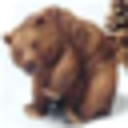

Text: There is a bear in this picture
Pipeline result = False
Ground truth class = bear


In [145]:
import random
from IPython.display import display

def find_animal_in_subset(animal_name, subset, classes):
    for i in range(len(subset)):
        img_tensor, lab = subset[i]
        if classes[lab] == animal_name:
            return img_tensor, lab
    return None, None

rand_animal = random.choice(selected_classes)
print("Randomly selected animal:", rand_animal)

img_tsr, lab_found = find_animal_in_subset(rand_animal, test_subset, test_full.classes)
if img_tsr is not None:
    arr = img_tsr.permute(1,2,0).numpy()
    arr = (arr*255).astype(np.uint8)
    pil_img = Image.fromarray(arr)

    # Display a bigger version
    pil_disp = pil_img.resize((128,128), Image.BICUBIC)
    display(pil_disp)

    text_example = f"There is a {rand_animal} in this picture"
    result = pipeline_inference(
        text_example,
        pil_img,
        ner_pipeline,
        animals_of_interest,
        animal_model,
        train_full.classes
    )
    print("Text:", text_example)
    print("Pipeline result =", result)
    print("Ground truth class =", test_full.classes[lab_found])
else:
    print(f"No {rand_animal} found in test subset.")

 Our current NER model simply isn’t catching  animal terms, so it’s not a good fit for this wildlife-focused task. We should consider using a domain-specific transformer or fine-tuning an existing model that’s been trained on animal-related text to ensure it can reliably recognize the animals we care about.

## Conclusion
We've shown:
1. **Task 1**: An OOP approach for MNIST classification with three models (RF, NN, CNN).
2. **Task 2**: A CNN for 10 animals on CIFAR-100, plus a **pretrained** NER from Hugging Face to detect any mention of those animals in text.
3. An end-to-end pipeline that compares recognized text animals to the CNN's predicted class.